<a href="https://colab.research.google.com/github/minkyeongk/DL_TensorFlow_Developer/blob/main/2.%20Convolutional%20Neural%20Networks%20in%20TensorFlow/week_3/week_3_notebook_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tranfer Learning Practice 

Inception v3 모델의 구조(layers, retrain되지 않도록 locked 한다.) 와 파라미터를 불러온 후 DNN을 추가하여 컴파일 한다. 추가한 DNN layer에 대한 Augmentation이 가능하다. 

이해한 바로는 inception 모델 부분은 건드리지 않고 가져다가 쓰고, 추가된 부분에 대해서만 training 진행 

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

# pre-trained weight 불러오기 
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# inception 모델에 pre-trained weights 불러오기
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False     # 기존 모델 retrain 되지 않도록 lock

pre_trained_model.summary()

# pre_trained 모델의 last layer이자 추가될 DNN의 input shape를 결정하는 layer 
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output 


--2021-01-12 16:28:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 2607:f8b0:400e:c04::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  95.8MB/s    in 0.9s    

2021-01-12 16:28:18 (95.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0           

In [2]:
from tensorflow.keras.optimizers import RMSprop
# DNN 추가 
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)    # add fully connected layer 
x = layers.Dropout(0.2)(x)    # to avoid overfitting 
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)   # 인자가 input output 같은데 
model.compile(optimizer=RMSprop(lr = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])   # 컴파일 마지막 인자 metrics

In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_gene = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

test_gene = ImageDataGenerator(rescale=1/255)

train_generator = train_gene.flow_from_directory(
    train_dir, 
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

test_generator = test_gene.flow_from_directory(
    validation_dir,
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

--2021-01-12 16:28:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   146MB/s    in 0.4s    

2021-01-12 16:28:56 (146 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs = 20,
    validation_data = test_generator,
    validation_steps = 50,
    verbose = 2   # fitting 과정 보여주는 방식 설정 
)

Epoch 1/20
100/100 - 28s - loss: 1.3367 - accuracy: 0.8445 - val_loss: 0.1859 - val_accuracy: 0.9400
Epoch 2/20
100/100 - 18s - loss: 0.3916 - accuracy: 0.8905 - val_loss: 0.2137 - val_accuracy: 0.9290
Epoch 3/20
100/100 - 18s - loss: 0.3372 - accuracy: 0.8990 - val_loss: 0.2940 - val_accuracy: 0.9140
Epoch 4/20
100/100 - 18s - loss: 0.2872 - accuracy: 0.9130 - val_loss: 0.1351 - val_accuracy: 0.9560
Epoch 5/20
100/100 - 18s - loss: 0.2949 - accuracy: 0.9170 - val_loss: 0.1545 - val_accuracy: 0.9480
Epoch 6/20
100/100 - 18s - loss: 0.2466 - accuracy: 0.9330 - val_loss: 0.1110 - val_accuracy: 0.9710
Epoch 7/20
100/100 - 18s - loss: 0.2460 - accuracy: 0.9250 - val_loss: 0.2095 - val_accuracy: 0.9500
Epoch 8/20
100/100 - 18s - loss: 0.2491 - accuracy: 0.9265 - val_loss: 0.1083 - val_accuracy: 0.9630
Epoch 9/20
100/100 - 17s - loss: 0.2331 - accuracy: 0.9280 - val_loss: 0.1158 - val_accuracy: 0.9720
Epoch 10/20
100/100 - 17s - loss: 0.1928 - accuracy: 0.9370 - val_loss: 0.1252 - val_accura

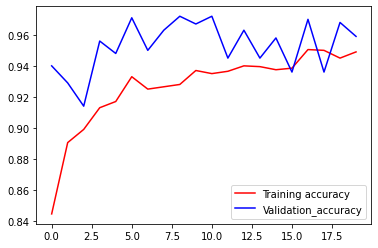

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation_accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()